In [2]:
import tensorflow as tf
import os
from utils import *
from tqdm import tqdm

In [6]:
attention_win_size = 3
max_N = 50
max_T = 120

def guided_attention(g=0.2):
    W = np.zeros((max_N, max_T), dtype=np.float32)
    for n_pos in range(W.shape[0]):
        for t_pos in range(W.shape[1]):
            W[n_pos, t_pos] = 1 - np.exp(-(t_pos / float(max_T) - n_pos / float(max_N)) ** 2 / (2 * g * g))
    return W

In [7]:
def Attention(Q, K, V, d, mononotic_attention=False, prev_max_attentions=None):
    A = tf.matmul(Q, K, transpose_b=True) * tf.rsqrt(tf.to_float(d))
    T = tf.shape(Q)[1]
    N = tf.shape(K)[1]
    if mononotic_attention:
        key_masks = tf.sequence_mask(prev_max_attentions, N)
        reverse_masks = tf.sequence_mask(N - attention_win_size - prev_max_attentions, N)[:, ::-1]
        masks = tf.logical_or(key_masks, reverse_masks)
        masks = tf.tile(tf.expand_dims(masks, 1), [1, T, 1])
        paddings = tf.ones_like(A) * (-2 ** 32 + 1)
        A = tf.where(tf.equal(masks, False), A, paddings)
    A = tf.nn.softmax(A)
    max_attentions = tf.argmax(A, -1)
    R = tf.matmul(A, V)
    R = tf.concat((R, Q), -1)

    alignments = tf.transpose(A, [0, 2, 1])

    return R, alignments, max_attentions

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def hc(inputs,
       filters=None,
       size=1,
       rate=1,
       padding="SAME",
       dropout_rate=0,
       use_bias=True,
       activation_fn=None,
       training=True,
       scope="hc",
       reuse=None):
    _inputs = inputs
    with tf.variable_scope(scope):
        if padding.lower() == "causal":
            pad_len = (size - 1) * rate
            inputs = tf.pad(inputs, [[0, 0], [pad_len, 0], [0, 0]])
            padding = "valid"

        if filters is None:
            filters = inputs.get_shape().as_list()[-1]


        params = {"inputs": inputs, "filters": 2*filters, "kernel_size": size,
                  "dilation_rate": rate, "padding": padding, "use_bias": use_bias,
                  "kernel_initializer": tf.contrib.layers.variance_scaling_initializer(), "reuse": reuse}

        tensor = tf.layers.conv1d(**params)
        H1, H2 = tf.split(tensor, 2, axis=-1)
        with tf.variable_scope('h1'):
            H1 = layer_norm(H1)
        with tf.variable_scope('h2'):
            H2 = layer_norm(H2)
        H1 = tf.nn.sigmoid(H1, "gate")
        H2 = activation_fn(H2, "info") if activation_fn is not None else H2
        tensor = H1*H2 + (1.-H1)*_inputs

    return tensor

def highwaynet(inputs, num_units=None, scope="highwaynet", reuse=None):
    if not num_units:
        num_units = inputs.get_shape()[-1]

    with tf.variable_scope(scope, reuse=reuse):
        H = tf.layers.dense(inputs, units=num_units, activation=tf.nn.relu, name="dense1")
        T = tf.layers.dense(inputs, units=num_units, activation=tf.nn.sigmoid,
                            bias_initializer=tf.constant_initializer(-1.0), name="dense2")
        outputs = H * T + inputs * (1. - T)
    return outputs

def conv1d_transpose(inputs,
                     filters=None,
                     size=3,
                     stride=2,
                     padding='same',
                     use_bias=True,
                     activation=None,
                     scope="conv1d_transpose",
                     reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        if filters is None:
            filters = inputs.get_shape().as_list()[-1]
        inputs = tf.expand_dims(inputs, 1)
        tensor = tf.layers.conv2d_transpose(inputs,
                                   filters=filters,
                                   kernel_size=(1, size),
                                   strides=(1, stride),
                                   padding=padding,
                                   activation=None,
                                   kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                   use_bias=use_bias)
        tensor = tf.squeeze(tensor, 1)
        tensor = layer_norm(tensor)
        if activation is not None:
            tensor = activation(tensor)

    return tensor

def conv1d(inputs,
           filters=None,
           size=1,
           rate=1,
           padding="SAME",
           use_bias=True,
           activation_fn=None,
           scope="conv1d",
           reuse=None):
    with tf.variable_scope(scope):
        if padding.lower() == "causal":
            pad_len = (size - 1) * rate
            inputs = tf.pad(inputs, [[0, 0], [pad_len, 0], [0, 0]])
            padding = "valid"

        if filters is None:
            filters = inputs.get_shape().as_list()[-1]

        params = {"inputs": inputs, "filters": filters, "kernel_size": size,
                  "dilation_rate": rate, "padding": padding, "use_bias": use_bias,
                  "kernel_initializer": tf.contrib.layers.variance_scaling_initializer(), "reuse": reuse}

        tensor = tf.layers.conv1d(**params)
        tensor = layer_norm(tensor)
        if activation_fn is not None:
            tensor = activation_fn(tensor)

    return tensor

def text_encoder(tensor, d):
    i = 2
    tensor = conv1d(tensor,
                    filters=2*d,
                    size=1,
                    rate=1,
                    activation_fn=tf.nn.relu,
                    scope="C_{}".format(i)); i += 1
    tensor = conv1d(tensor,
                    size=1,
                    rate=1,
                    scope="C_{}".format(i)); i += 1

    for _ in range(2):
        for j in range(4):
            tensor = hc(tensor,
                            size=3,
                            rate=3**j,
                            activation_fn=None,
                            scope="HC_{}".format(i)); i += 1
    for _ in range(2):
        tensor = hc(tensor,
                        size=3,
                        rate=1,
                        activation_fn=None,
                        scope="HC_{}".format(i)); i += 1

    for _ in range(2):
        tensor = hc(tensor,
                        size=1,
                        rate=1,
                        activation_fn=None,
                        scope="HC_{}".format(i)); i += 1

    K, V = tf.split(tensor, 2, -1)
    return K, V

def audio_encoder(S, d):
    i = 1
    tensor = conv1d(S,
                    filters=d,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    activation_fn=tf.nn.relu,
                    scope="C_{}".format(i)); i += 1
    tensor = conv1d(tensor,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    activation_fn=tf.nn.relu,
                    scope="C_{}".format(i)); i += 1
    tensor = conv1d(tensor,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    scope="C_{}".format(i)); i += 1
    for _ in range(2):
        for j in range(4):
            tensor = hc(tensor,
                            size=3,
                            rate=3**j,
                            padding="CAUSAL",
                            scope="HC_{}".format(i)); i += 1
    for _ in range(2):
        tensor = hc(tensor,
                        size=3,
                        rate=3,
                        padding="CAUSAL",
                        scope="HC_{}".format(i)); i += 1

    return tensor

def audio_decoder(R, d):
    i = 1
    tensor = conv1d(R,
                    filters=d,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    scope="C_{}".format(i)); i += 1
    for j in range(4):
        tensor = hc(tensor,
                        size=3,
                        rate=3**j,
                        padding="CAUSAL",
                        scope="HC_{}".format(i)); i += 1

    for _ in range(2):
        tensor = hc(tensor,
                        size=3,
                        rate=1,
                        padding="CAUSAL",
                        scope="HC_{}".format(i)); i += 1
    for _ in range(3):
        tensor = conv1d(tensor,
                        size=1,
                        rate=1,
                        padding="CAUSAL",
                        activation_fn=tf.nn.relu,
                        scope="C_{}".format(i)); i += 1
    logits = conv1d(tensor,
                    filters=n_mels * resampled,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    scope="C_{}".format(i)); i += 1
    Y = tf.nn.sigmoid(logits)

    return logits, Y

def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

class Model:
    def __init__(
        self,
        num_layers,
        size_layers,
        learning_rate = 1e-4,
        kernel_size = 5
    ):
        self.X = tf.placeholder(tf.int32, (None, None))
        lookup_table = tf.get_variable(
            'lookup_table',
            dtype = tf.float32,
            shape = [len(vocab), size_layers],
            initializer = tf.truncated_normal_initializer(
                mean = 0.0, stddev = 0.01
            ),
        )
        lookup_table = tf.concat(
            (tf.zeros(shape = [1, size_layers]), lookup_table[1:, :]), 0
        )
        self.gts = tf.convert_to_tensor(guided_attention())
        forward = tf.nn.embedding_lookup(lookup_table, self.X)
        self.Y = tf.placeholder(tf.float32, (None, None, n_mels * resampled))
        batch_size = tf.shape(self.Y)[0]
        self.decoder_inputs = tf.concat(
            (tf.ones_like(self.Y[:, :1, :]), self.Y[:, :-1, :]), 1
        )
        self.decoder_inputs = self.decoder_inputs[:, :, -n_mels:]
        
        self.Z = tf.placeholder(
            tf.float32, (None, None, fourier_window_size // 2 + 1)
        )
        self.prev_max_attentions = tf.placeholder(tf.int32, shape=(1,))
        
        with tf.variable_scope("text_encoder"):
            K, V = text_encoder(forward, size_layers)
        with tf.variable_scope("audio_encoder"):
            Q = audio_encoder(self.decoder_inputs, size_layers)
        
        train_R, self.alignments, train_max_attentions = Attention(Q, K, V, size_layers,
                                                                 mononotic_attention=False,
                                                                 prev_max_attentions=self.prev_max_attentions)
        
        test_R, _, self.max_attentions = Attention(Q, K, V, size_layers,
                                                                 mononotic_attention=True,
                                                                 prev_max_attentions=self.prev_max_attentions)
        
        with tf.variable_scope("audio_decoder"):
            self.train_Y_logits, self.train_Y_hat = audio_decoder(train_R, size_layers)
            
        with tf.variable_scope("audio_decoder", reuse = True):
            self.test_Y_logits, self.test_Y_hat = audio_decoder(test_R, size_layers)
        
        out_decoder = tf.reshape(
                self.Y, [tf.shape(self.Y)[0], -1, n_mels]
        )
        out_decoder = tf.layers.dense(out_decoder, size_layers)
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_vocoder_%d'%i):
                out_decoder += cnn_block(out_decoder, dilation_rate, pad_sz, size_layers, kernel_size)
        
        self.Z_logits = tf.layers.dense(out_decoder, 1 + fourier_window_size // 2)
        self.Z_hat = tf.sigmoid(self.Z_logits)
        
        self.loss1 = tf.reduce_mean(tf.abs(self.train_Y_hat - self.Y))
        self.loss_bd1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.train_Y_logits, 
                                                                               labels=self.Y))
        self.loss2 = tf.reduce_mean(tf.abs(self.Z_hat - self.Z))
        self.loss_bd2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.Z_logits, 
                                                                          labels=self.Z))
        
        self.loss1 = tf.reduce_mean(tf.abs(self.train_Y_hat - self.Y))
        self.loss_bd1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.train_Y_logits, 
                                                                               labels=self.Y))
        self.A = tf.pad(self.alignments, [(0, 0), (0, max_N), (0, max_T)], 
                        mode="CONSTANT", constant_values=-1.)[:, :max_N, :max_T]
        self.attention_masks = tf.to_float(tf.not_equal(self.A, -1))
        self.loss_att = tf.reduce_sum(tf.abs(self.A * self.gts) * self.attention_masks)
        self.mask_sum = tf.reduce_sum(self.attention_masks)
        self.loss_att /= self.mask_sum
        
        self.loss = self.loss1 + self.loss2 + self.loss_bd1 + self.loss_bd2 + self.loss_att
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.loss)

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

size_layers = 128
learning_rate = 1e-4
num_layers = 4

model = Model(num_layers, size_layers, learning_rate)
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [9]:
paths, lengths, texts, raw_texts = [], [], [], []
text_files = [f for f in os.listdir('./mel') if f.endswith('.npy')]
for fpath in text_files:
    text = ' '.join([i for i in os.path.splitext(fpath)[0].split('-') if not i.isdigit()])
    paths.append(fpath.replace('.npy', ''))
    text = text_normalize(text)
    raw_texts.append(text)
    text = text + 'E'
    texts.append(np.array([char2idx[char] for char in text], np.int32))
    lengths.append(len(text))

In [10]:
def dynamic_batching(paths):
    files, max_y, max_z = [], 0, 0
    for n in range(len(paths)):
        files.append(get_cached(paths[n]))
        if files[-1][0].shape[0] > max_y:
            max_y = files[-1][0].shape[0]
        if files[-1][1].shape[0] > max_z:
            max_z = files[-1][1].shape[0]
    return files, max_y, max_z

minibatch loop: 100%|██████████| 46/46 [00:24<00:00,  2.72it/s, cost=1.83, loss1=0.389, loss2=0.179, loss_att=0.00211, loss_bd1=0.79, loss_bd2=0.474] 


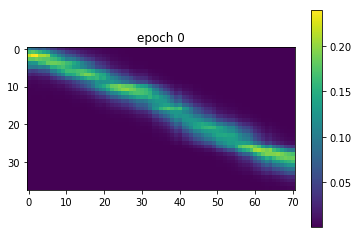

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.53, loss1=0.375, loss2=0.0637, loss_att=0.00086, loss_bd1=0.772, loss_bd2=0.315] 


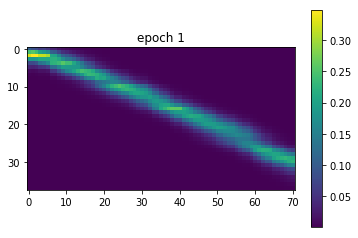

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.48, loss1=0.368, loss2=0.0498, loss_att=0.000537, loss_bd1=0.757, loss_bd2=0.301]


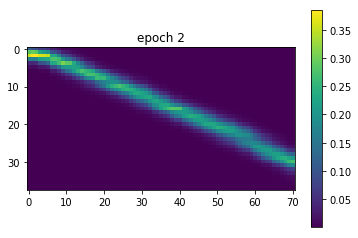

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.45, loss1=0.365, loss2=0.0451, loss_att=0.000384, loss_bd1=0.747, loss_bd2=0.297]


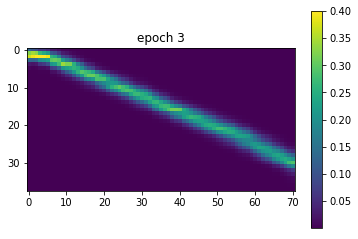

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.96it/s, cost=1.44, loss1=0.364, loss2=0.0415, loss_att=0.000323, loss_bd1=0.739, loss_bd2=0.295]


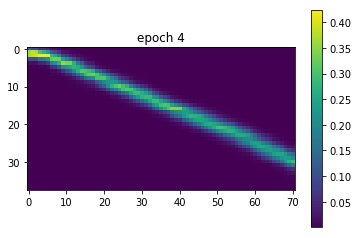

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.96it/s, cost=1.43, loss1=0.363, loss2=0.0387, loss_att=0.000278, loss_bd1=0.733, loss_bd2=0.293]


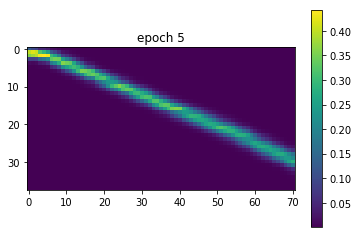

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.42, loss1=0.364, loss2=0.0364, loss_att=0.000252, loss_bd1=0.726, loss_bd2=0.291]


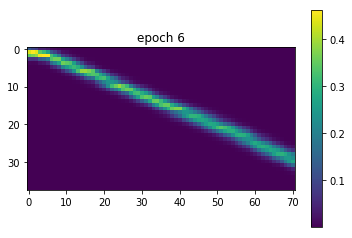

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.41, loss1=0.365, loss2=0.0347, loss_att=0.000231, loss_bd1=0.717, loss_bd2=0.29] 


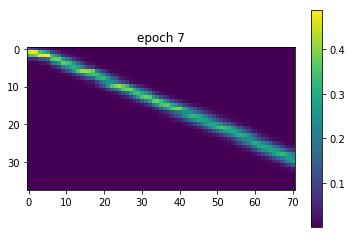

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.4, loss1=0.365, loss2=0.0334, loss_att=0.000216, loss_bd1=0.71, loss_bd2=0.289]  


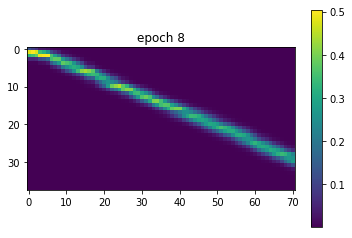

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.39, loss1=0.365, loss2=0.0324, loss_att=0.000202, loss_bd1=0.704, loss_bd2=0.289]


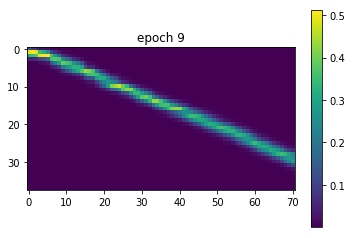

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.38, loss1=0.364, loss2=0.0316, loss_att=0.000198, loss_bd1=0.699, loss_bd2=0.288]


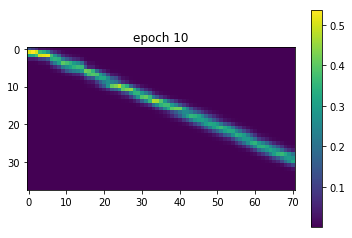

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.98it/s, cost=1.38, loss1=0.363, loss2=0.0309, loss_att=0.000204, loss_bd1=0.696, loss_bd2=0.288]


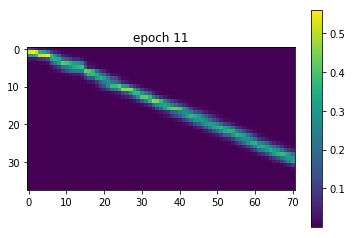

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.37, loss1=0.361, loss2=0.0303, loss_att=0.000182, loss_bd1=0.694, loss_bd2=0.288]


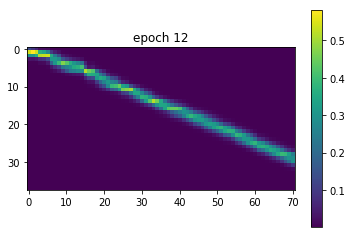

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.37, loss1=0.36, loss2=0.0297, loss_att=0.000176, loss_bd1=0.691, loss_bd2=0.287] 


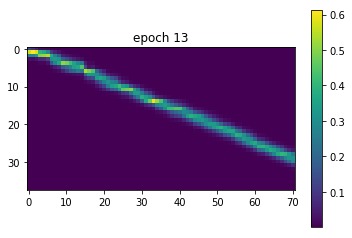

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.36, loss1=0.359, loss2=0.0292, loss_att=0.000172, loss_bd1=0.688, loss_bd2=0.287]


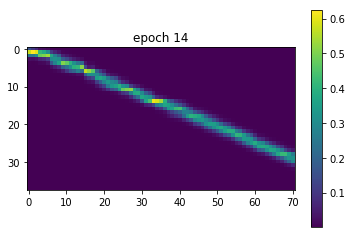

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.98it/s, cost=1.36, loss1=0.358, loss2=0.0288, loss_att=0.000162, loss_bd1=0.686, loss_bd2=0.287]


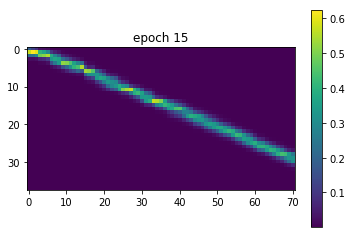

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.98it/s, cost=1.36, loss1=0.357, loss2=0.0285, loss_att=0.000152, loss_bd1=0.683, loss_bd2=0.287]


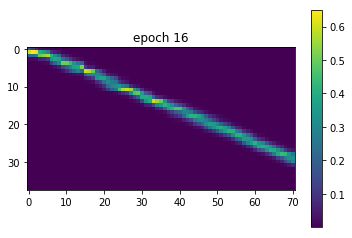

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.96it/s, cost=1.35, loss1=0.357, loss2=0.0282, loss_att=0.000143, loss_bd1=0.68, loss_bd2=0.287] 


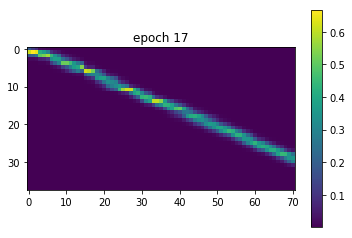

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.98it/s, cost=1.35, loss1=0.356, loss2=0.0279, loss_att=0.000137, loss_bd1=0.677, loss_bd2=0.286]


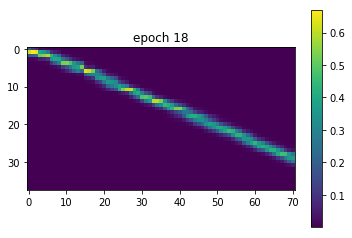

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.98it/s, cost=1.34, loss1=0.356, loss2=0.0277, loss_att=0.000132, loss_bd1=0.673, loss_bd2=0.286]


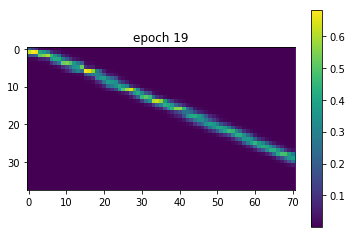

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.96it/s, cost=1.34, loss1=0.355, loss2=0.0275, loss_att=0.000129, loss_bd1=0.67, loss_bd2=0.286] 


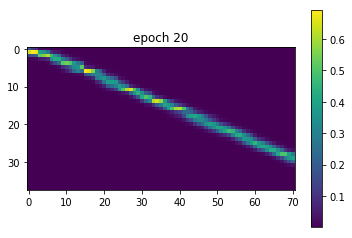

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.34, loss1=0.354, loss2=0.0274, loss_att=0.000127, loss_bd1=0.668, loss_bd2=0.286]


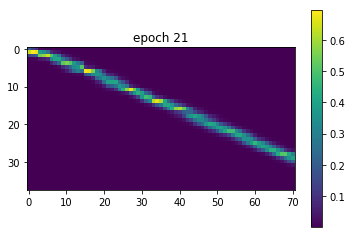

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.33, loss1=0.353, loss2=0.0272, loss_att=0.000136, loss_bd1=0.666, loss_bd2=0.286]


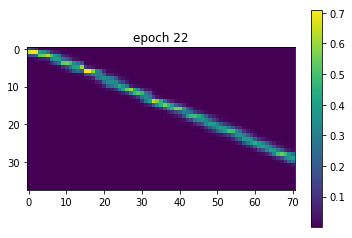

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.33, loss1=0.352, loss2=0.0271, loss_att=0.000128, loss_bd1=0.664, loss_bd2=0.286]


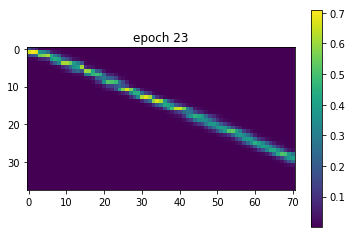

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.33, loss1=0.35, loss2=0.027, loss_att=0.000122, loss_bd1=0.662, loss_bd2=0.286]  


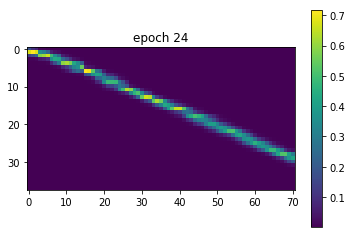

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.97it/s, cost=1.32, loss1=0.349, loss2=0.0269, loss_att=0.00012, loss_bd1=0.66, loss_bd2=0.286]  


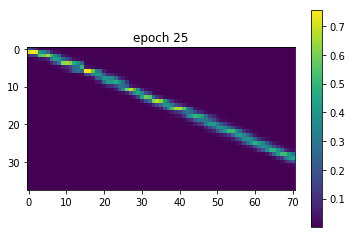

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.32, loss1=0.348, loss2=0.0268, loss_att=0.000123, loss_bd1=0.658, loss_bd2=0.286]


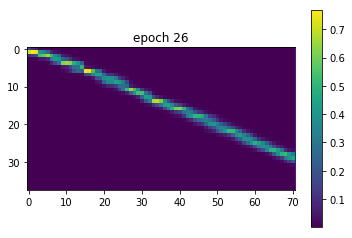

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.32, loss1=0.347, loss2=0.0267, loss_att=0.000114, loss_bd1=0.656, loss_bd2=0.286]


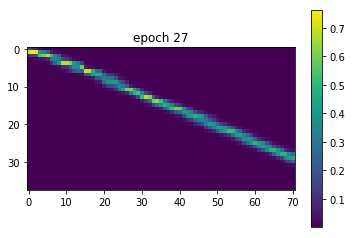

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.31, loss1=0.345, loss2=0.0266, loss_att=0.000116, loss_bd1=0.654, loss_bd2=0.286]


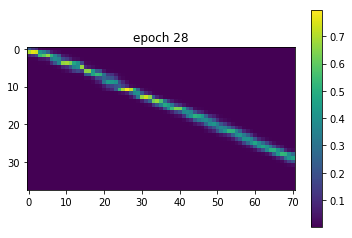

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.99it/s, cost=1.31, loss1=0.344, loss2=0.0265, loss_att=0.000112, loss_bd1=0.652, loss_bd2=0.286]


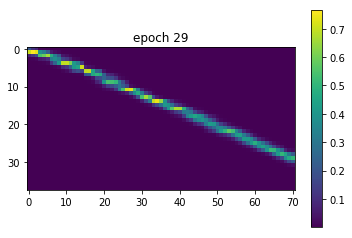

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.31, loss1=0.343, loss2=0.0264, loss_att=0.00011, loss_bd1=0.65, loss_bd2=0.286]  


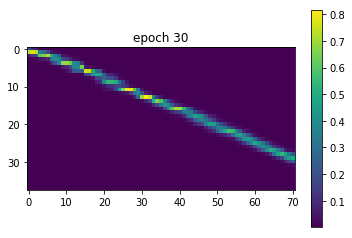

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.3, loss1=0.342, loss2=0.0263, loss_att=0.000109, loss_bd1=0.648, loss_bd2=0.286] 


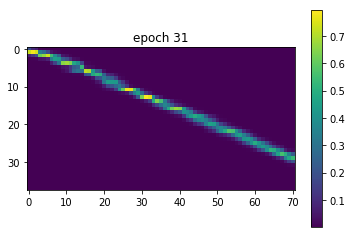

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.3, loss1=0.34, loss2=0.0263, loss_att=0.000108, loss_bd1=0.646, loss_bd2=0.286]  


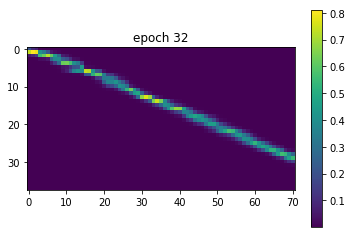

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.97it/s, cost=1.3, loss1=0.339, loss2=0.0262, loss_att=0.000115, loss_bd1=0.644, loss_bd2=0.286] 


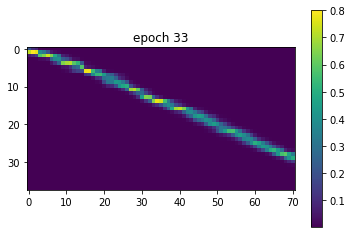

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.29, loss1=0.338, loss2=0.0261, loss_att=0.000112, loss_bd1=0.642, loss_bd2=0.286]


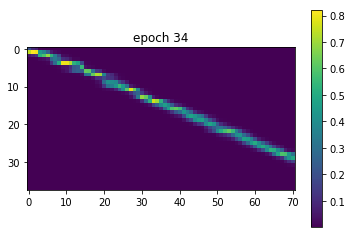

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.97it/s, cost=1.29, loss1=0.337, loss2=0.026, loss_att=0.000106, loss_bd1=0.64, loss_bd2=0.286]  


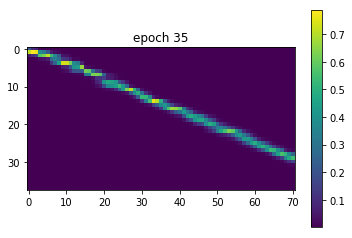

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.28, loss1=0.335, loss2=0.026, loss_att=0.000108, loss_bd1=0.638, loss_bd2=0.286] 


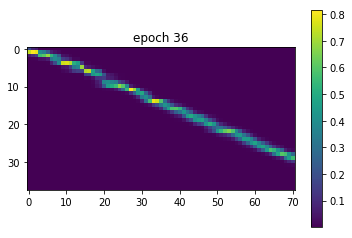

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.28, loss1=0.334, loss2=0.0259, loss_att=0.00011, loss_bd1=0.636, loss_bd2=0.286] 


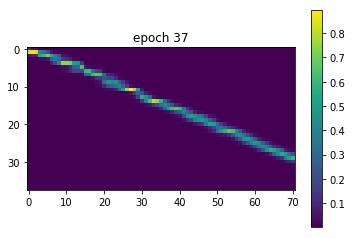

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.96it/s, cost=1.28, loss1=0.333, loss2=0.0258, loss_att=0.00011, loss_bd1=0.634, loss_bd2=0.285] 


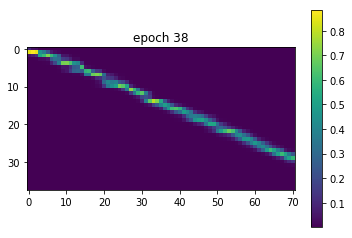

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.27, loss1=0.331, loss2=0.0258, loss_att=0.000111, loss_bd1=0.632, loss_bd2=0.285]


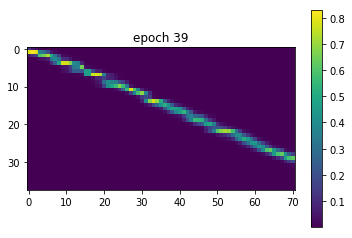

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.27, loss1=0.33, loss2=0.0257, loss_att=0.000104, loss_bd1=0.63, loss_bd2=0.285]  


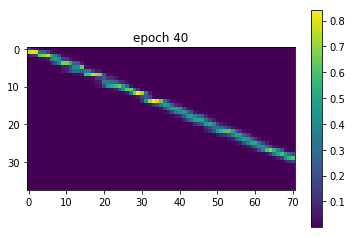

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.97it/s, cost=1.27, loss1=0.328, loss2=0.0257, loss_att=0.000104, loss_bd1=0.628, loss_bd2=0.285]


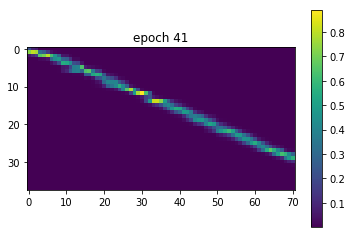

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.26, loss1=0.327, loss2=0.0256, loss_att=0.000113, loss_bd1=0.626, loss_bd2=0.285]


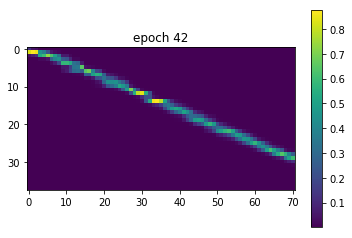

minibatch loop: 100%|██████████| 46/46 [00:16<00:00,  2.97it/s, cost=1.26, loss1=0.325, loss2=0.0256, loss_att=0.000107, loss_bd1=0.624, loss_bd2=0.285]


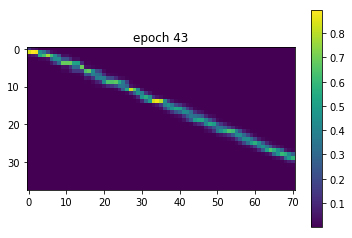

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.26, loss1=0.324, loss2=0.0255, loss_att=0.000113, loss_bd1=0.622, loss_bd2=0.285]


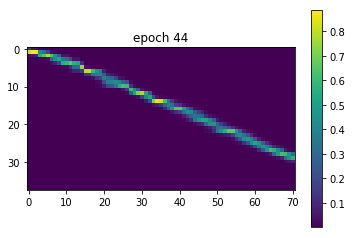

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.25, loss1=0.322, loss2=0.0254, loss_att=0.000111, loss_bd1=0.62, loss_bd2=0.285] 


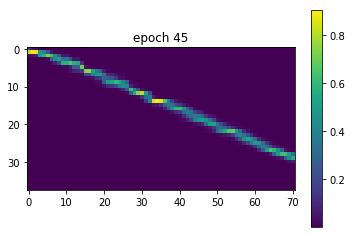

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.99it/s, cost=1.25, loss1=0.32, loss2=0.0254, loss_att=0.000115, loss_bd1=0.618, loss_bd2=0.285] 


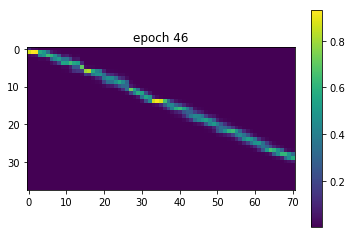

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.25, loss1=0.318, loss2=0.0253, loss_att=0.000102, loss_bd1=0.616, loss_bd2=0.285]


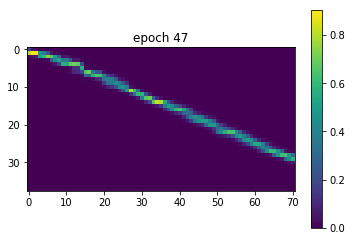

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.98it/s, cost=1.24, loss1=0.317, loss2=0.0253, loss_att=0.000103, loss_bd1=0.614, loss_bd2=0.285]


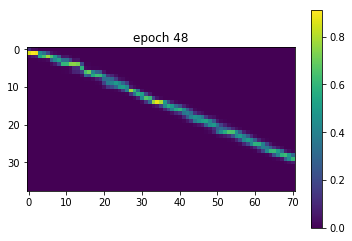

minibatch loop: 100%|██████████| 46/46 [00:15<00:00,  2.99it/s, cost=1.24, loss1=0.314, loss2=0.0252, loss_att=9.96e-5, loss_bd1=0.612, loss_bd2=0.285] 


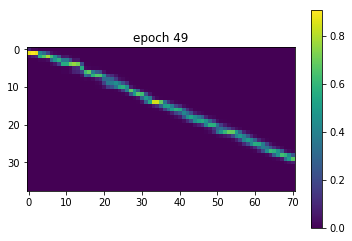

In [11]:
EPOCH = 50
for i in range(EPOCH):
    pbar = tqdm(range(0, len(paths), batch_size), desc = 'minibatch loop')
    for k in pbar:
        index = min(k + batch_size, len(paths))
        files, max_y, max_z = dynamic_batching(paths[k:index])
        max_x = max(lengths[k:index])
        batch_x = np.zeros((batch_size, max_x))
        batch_y = np.zeros((batch_size, max_y, n_mels * resampled))
        batch_z = np.zeros((batch_size, max_z, fourier_window_size // 2 + 1))
        for n in range(len(files)):
            batch_x[n, :] = np.pad(
                texts[k + n],
                ((0, max_x - texts[k + n].shape[0])),
                mode = 'constant',
            )
            batch_y[n, :, :] = np.pad(
                files[n][0],
                ((0, max_y - files[n][0].shape[0]), (0, 0)),
                mode = 'constant',
            )
            batch_z[n, :, :] = np.pad(
                files[n][1],
                ((0, max_z - files[n][1].shape[0]), (0, 0)),
                mode = 'constant',
            )
        _, cost, loss1, loss2, loss_bd1, loss_att, loss_bd2 = sess.run(
            [model.optimizer, model.loss, 
            model.loss1, model.loss2, model.loss_bd1,
            model.loss_att, model.loss_bd2],
            feed_dict = {model.X: batch_x, model.Y: batch_y, model.Z: batch_z},
        )
        pbar.set_postfix(cost = cost, loss1 = loss1, loss2 = loss2, loss_bd1 = loss_bd1,
                        loss_att = loss_att, loss_bd2 = loss_bd2)
        
    align = sess.run(
        model.alignments, feed_dict = {model.X: batch_x, model.Y: batch_y}
    )
    plot_alignment(align[0, :, :], i)

In [12]:
y_hat = np.ones((1, batch_y.shape[1], n_mels * resampled), np.float32)
max_attention = np.zeros((1), np.int32)
for j in tqdm(range(batch_y.shape[1])):
    _y_hat, attention = sess.run([model.test_Y_hat, model.max_attentions], 
                                 {model.X: [texts[0]], model.Y: y_hat,
                                  model.prev_max_attentions: max_attention})
    y_hat[:, j, :] = _y_hat[:, j, :]
    max_attention = attention[:, j]

100%|██████████| 71/71 [00:01<00:00, 70.32it/s]


In [13]:
mags = sess.run(model.Z_hat, {model.Y: y_hat})
audio = spectrogram2wav(mags[0])

In [14]:
import IPython.display as ipd
ipd.Audio(audio, rate = sample_rate)

In [15]:
from scipy.io.wavfile import write
write(os.path.join('test-deep-cnn-monothonic-attention.wav'), sample_rate, audio)

In [16]:
mags = sess.run(model.Z_hat, {model.Y: [batch_y[0]]})
audio = spectrogram2wav(mags[0])
ipd.Audio(audio, rate = sample_rate)

In [17]:
real_audio = spectrogram2wav(batch_z[0])
ipd.Audio(real_audio, rate = sample_rate)